# 1. Problem Description and Anomaly Typology

**The problem addressed** is the identification of musical tracks that do not belong to the *"Classical"* genre within a mislabeled dataset. Regarding the typology of anomalies, we are dealing with **Global Outliers**.

* **Why Global?** The identified tracks possess audio characteristics (*Energy > 0.9*, *Acousticness < 0.01*) that fall completely outside the value range specific to classical music. They are not merely slightly different (local anomalies), but are located at the opposite extremity of the vector space.

* **Structure:** Although they are individual points, considering that we identified multiple tracks from the same band (e.g., 5 Dream Theater tracks), these could also be considered *anomaly micro-clusters*. However, relative to the dataset size (1000 tracks), they are treated as punctual global outliers.

# 2. Dataset Selection and Exploration

**Dataset:** For this project, I used the *"Spotify Tracks Dataset"* (available on Kaggle). It contains over 114,000 musical tracks from 114 different genres, each described by automatically extracted numerical audio features (e.g., *energy, acousticness, loudness, tempo, valence*).

**Motivation:** This dataset is ideal for anomaly detection because:
1. It is a **real and multidimensional** dataset, reflecting the complexity of audio classification.
2. It allows for a clear definition of *"normality"* (the Classical genre - characterized by acoustic instruments and high dynamics) and *"anomalies"* (tracks from other genres erroneously infiltrated).

**Problem Definition:** We aim to detect **contextual anomalies** within the *"Classical"* genre.
* **Hypothesis:** A classical music playlist should be acoustically homogeneous.
* **Type of Anomalies Sought:** Tracks that, although labeled as *"Classical"*, exhibit audio characteristics of **Rock, Metal, or Pop** genres (extreme energy, electric instruments, consistently high volume).

---

## 2.1. Data Preprocessing and Cleaning (Noise Removal)

In the initial exploration phase, I identified a major label consistency issue: the *"Classical"* category included both Western Classical music (Mozart, Bach) and **Indian Classical Music** (Carnatic, Hindustani).

* **Problem:** Indian music has a much faster rhythmic structure and prominent percussion, giving it high energy values, introducing "statistical noise" (being falsely detected as an anomaly by the models). Additionally, I am not as familiar with Indian music, so I could not decide with certainty if the detected anomalies were correct.
* **Action:** I implemented a cleaning filter based on a *"blacklist"* of specific non-Western style artists to preserve only the distribution of Western classical music and correctly isolate genre anomalies.

---

## 2.2. Variable Distribution Analysis and Visualization

I analyzed the variable distribution to understand which features are relevant in detecting intruders. I divided the attributes into two categories:

### A. Primary Discriminators (Genre Signature)
These are the features that most clearly separate Classical Music from Rock/Metal:
* **Acousticness:** The distribution is strongly skewed to the right (most values > 0.8). This is the strongest indicator: classical is acoustic, while the sought anomalies are electric (values < 0.01).
* **Energy:** Most classical tracks are concentrated in the [0.0 - 0.3] range. Extreme values (> 0.8) are suspicious and indicate the presence of drums and distortion.

### B. Secondary Factors and Dynamics Analysis
* **Loudness (Volume):** I observed a fundamental difference in dynamics. Classical music has a wide dynamic range (moments of silence alternating with fortissimo), having a low average volume (approx. -20dB). In contrast, Rock/Pop tracks are "compressed" and maintain a constantly high volume (approx. -5dB).
* **Tempo:** Although I analyzed track speed, I found that this is not a perfect discriminator (there are very fast Vivaldi tracks, just like Metal ones). This insight later led to the decision to penalize the importance of tempo in modeling.

---

## 2.3. Data Normalization and Preparation

Since anomaly detection algorithms (especially KNN and SVM) are sensitive to value scaling, preprocessing included two essential steps:

1. **Normalization (MinMax Scaling):** I transformed all numerical features into the [0, 1] range to ensure a fair contribution to distance calculation.
2. **Feature Engineering (Weighting):** Based on the analysis in section 2.2, I applied **custom weights** to the input vectors. I artificially amplified the importance of certain features, as I will present below.

Number of raw 'Classical' tracks: 1000
Number of tracks after cleaning: 827


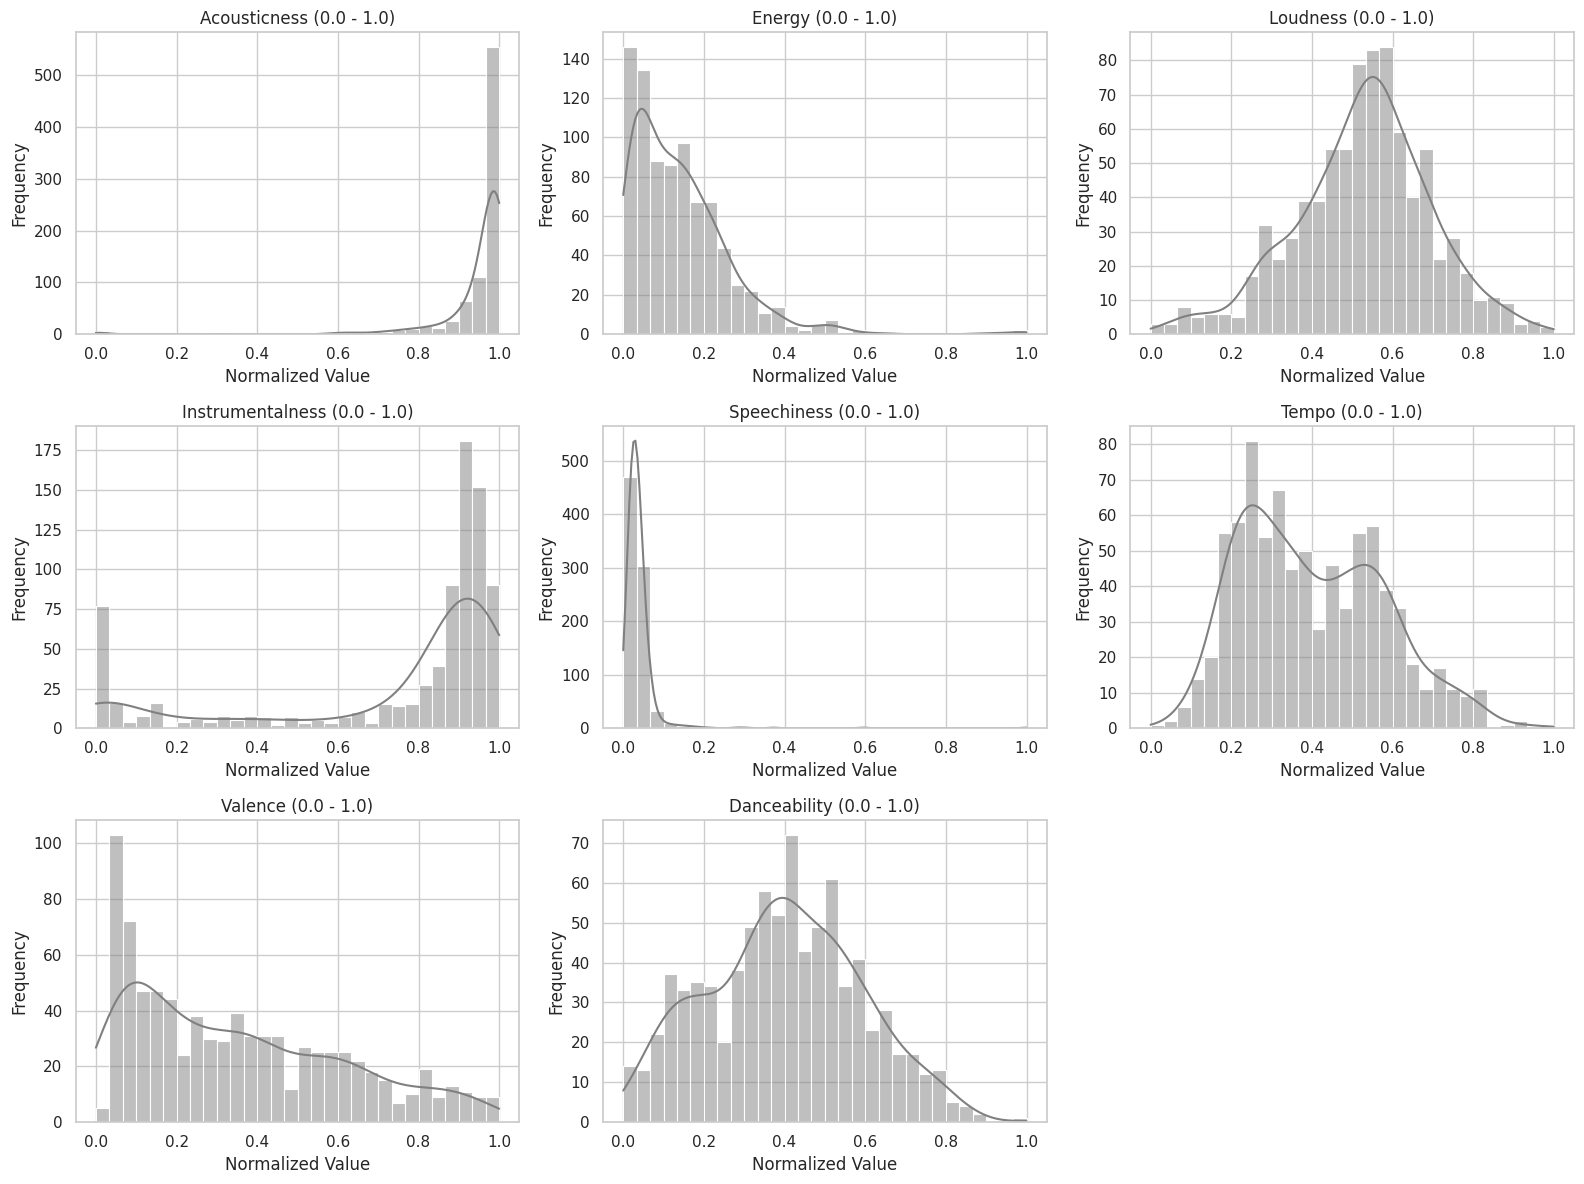


--- DESCRIPTIVE STATISTICS (NORMALIZED DATA, NO WEIGHTS) ---
                  count    mean     std  min     25%     50%     75%  max
acousticness      827.0  0.9508  0.1070  0.0  0.9528  0.9859  0.9960  1.0
energy            827.0  0.1413  0.1246  0.0  0.0479  0.1179  0.2024  1.0
loudness          827.0  0.5270  0.1684  0.0  0.4279  0.5369  0.6304  1.0
instrumentalness  827.0  0.7356  0.3277  0.0  0.7088  0.9022  0.9399  1.0
speechiness       827.0  0.0376  0.0481  0.0  0.0205  0.0304  0.0436  1.0
tempo             827.0  0.4005  0.1765  0.0  0.2509  0.3743  0.5384  1.0
valence           827.0  0.3540  0.2623  0.0  0.1173  0.3012  0.5471  1.0
danceability      827.0  0.3996  0.1918  0.0  0.2648  0.4061  0.5274  1.0


In [2]:
!pip install pyod

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import zipfile
import os

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ---------------------------------------------------------
# 1. DATA LOADING
# ---------------------------------------------------------
if not os.path.exists('dataset.csv'):
    if os.path.exists('dataset.csv.zip'):
        with zipfile.ZipFile('dataset.csv.zip', 'r') as zip_ref:
            zip_ref.extractall()
    else:
        print("Error: dataset.csv not found")

try:
    df = pd.read_csv('dataset.csv')
except:
    df = pd.DataFrame()

if not df.empty:
    # Filter only the 'Classical' genre
    df_classical_raw = df[df['track_genre'] == 'classical'].copy().reset_index(drop=True)
    print(f"Number of raw 'Classical' tracks: {len(df_classical_raw)}")

    # ---------------------------------------------------------
    # 2. DATA CLEANING (BLACKLIST)
    # Remove irrelevant artists
    # ---------------------------------------------------------
    blacklist_artists = [
        'Sirkazhi Govindarajan', 'Sirkazhi G. Sivachidambaram',
        'Bombay Jayashri', 'Bombay Sisters', 'M. S. Subbulakshmi',
        'Nithyasree Mahadevan', 'Nithyasree', 'Soolamangalam Sisters',
        'Mambalam Sisters', 'Priya Sisters', 'Bhimsen Joshi', 'Pandit Jasraj',
        'Rahul Deshpande', 'Vasantrao Deshpande', 'Shankar', 'Ehsaan', 'Loy',
        'Gulzar', 'Alisha Chinai', 'Ajoy Chakrabarty', 'Parveen Sultana',
        'Prasanna', 'Rajhesh Vaidhya', 'Kala Ramnath', 'Radha Jayalakshmi',
        'Jayateerth Mevundi', 'Mahesh Raghvan', 'Purbayan Chatterjee',
        'Kadri Gopalnath', 'Vedavathi Prabhakar', 'Sikkil Gurucharan',
        'V. Selvaganesh', 'Karthik', 'Chinmayi', 'Chaya Devi', 'Rajani Shridhar',
        'Sangeetha Katti', 'Gundecha Brothers', 'Malladi Brothers',
        'Hyderabad Brothers', 'Sudha Ragunathan', 'Aruna Sairam', 'T. M. Krishna',
        'Rakesh Chaurasia', 'Sultan Khan', 'Ramesh Mishra', 'A. Kanyakumari',
        'M. Balamuralikrishna', 'Bickram Ghosh', 'Niladri Kumar', 'Prasad Sawkar',
        'Kumar Gandharva', 'Veena Sahasrabuddhe', 'Madurai Somasundaram',
        'Jitendra Abhisheki', 'Bade Ghulam Ali Khan', 'Shivkumar Sharma',
        'Lalgudi G. Jayaraman', 'Sanjeev Abhyankar', 'Begum Akhtar',
        'K. B. Sundarambal', 'Ramakrishnan Murthy', 'Kishori Amonkar',
        'M. L. Vasanthakumari', 'Shobha Gurtu', 'Pithukuli Murugadas',
        'Sanjay Subrahmanyan', 'Sreevalsan J. Menon', 'Kedar Pandit',
        'Tushar Dutta', 'Manik Varma', 'Hariprasad Chaurasia', 'Ram Narayan',
        'T. R. Mahalingam', 'Rattan Mohan Sharma', 'Rashid Khan',
        'S. Sowmya', 'Gen Hoshino', 'Ben Woodward', 'Ingrid Michaelson'
    ]

    def is_blacklisted(artist_name):
        name_lower = str(artist_name).lower()
        for banned in blacklist_artists:
            if banned.lower() in name_lower:
                return True
        return False

    mask = df_classical_raw['artists'].apply(is_blacklisted)
    df_classical = df_classical_raw[~mask].reset_index(drop=True)
    print(f"Number of tracks after cleaning: {len(df_classical)}")

    # ---------------------------------------------------------
    # 3. NORMALIZATION (NO WEIGHTS)
    # I want to see the natural distribution of data scaled between 0 and 1
    # ---------------------------------------------------------
    features_to_analyze = [
        'acousticness', 'energy', 'loudness', 'instrumentalness',
        'speechiness', 'tempo', 'valence', 'danceability'
    ]

    X = df_classical[features_to_analyze]

    # Normalize data (MinMax)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a DataFrame for visualization
    df_scaled = pd.DataFrame(X_scaled, columns=features_to_analyze)

    # ---------------------------------------------------------
    # 4. VISUALIZATION AND STATISTICS
    # ---------------------------------------------------------
    plt.figure(figsize=(16, 12))
    for i, col in enumerate(features_to_analyze, 1):
        plt.subplot(3, 3, i)
        # Use a neutral color
        sns.histplot(df_scaled[col], kde=True, color='gray', bins=30)
        plt.title(f'{col.capitalize()} (0.0 - 1.0)')
        plt.xlabel('Normalized Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print statistics for analysis
    print("\n--- DESCRIPTIVE STATISTICS (NORMALIZED DATA, NO WEIGHTS) ---")
    # Transpose the table (.T) for easier reading/copying
    print(df_scaled.describe().round(4).T)

# 3. Feature Weight Tuning based on Exploratory Analysis (Data-Driven Tuning)

After visualizing the natural distribution of the data (normalized between 0 and 1, without external influences), I was able to identify the "digital signature" of the *Classical* genre and established the final weighting strategy to maximize anomaly detection (Rock/Metal genres).

I analyzed the histograms generated above and made the following strategic decisions:

### 1. Acousticness (Weight: 5.0 - Maximum)
* **Observation:** The graph shows a massive concentration of data towards the value **1.0** (mean is 0.95). It is the most homogeneous feature of the dataset.
* **Decision:** Since classical music is almost exclusively acoustic, and the sought anomalies (Metal/Electronic) have values close to 0, I allocated the highest weight to this attribute. It is the primary discriminator.

### 2. Loudness and Energy (Weights: 4.0 and 3.0 - Very High)
* **Observation:**
    * **Energy:** The distribution is strongly skewed to the left (low values, mean 0.14).
    * **Loudness:** Although it follows a normal distribution, the mean is low.
* **Decision:** Modern genres (Rock/Pop) are characterized by dynamic compression and high volume ("Loudness War"). By increasing the weight, I force the model to consider any track with high energy as suspicious.

### 3. Instrumentalness (Weight: 4.0 - Very High)
* **Observation:** Most tracks are instrumental (> 0.9), but there is a "tail" of vocal tracks (Opera).
* **Decision:** To detect Rock and Pop (which are predominantly vocal genres), it is crucial to penalize the lack of instrumentality. I increased the weight to 4.0, accepting the risk of flagging some opera arias as anomalies, to guarantee the elimination of lyrical tracks from other genres.

### 4. Speechiness (Weight: 3.0 - High)
* **Observation:** This feature detects the presence of spoken words (rap, podcasts). Classical music has minimal values.
* **Decision:** Although both genres are "sung", I set a high weight (3.0) to additionally penalize any track with a dense or rhythmic vocal structure (specific to modern music), helping differentiate it from instrumental music.

### 5. Tempo (Weight: 0.05 - Negligible)
* **Observation:** The histogram shows a wide and scattered distribution of tempo. There are very slow classical pieces (*Largo*), but also very fast ones (*Presto*).
* **Decision:** Speed (BPM) is not a valid criterion to distinguish Classical Music from Rock (both can be fast). I reduced the weight almost to zero to protect virtuous pieces (e.g., Vivaldi) from being erroneously classified as anomalies solely due to speed.

### 6. Negligible Features (Weight: 0.1)
* **Attributes:** *Valence* (Emotion), *Danceability*, *Liveness* (Audience presence).
* **Decision:** These attributes are not specific to a single genre (a classical piece can be sad or happy, just like a rock one). I allocated them a minimal weight (0.1) to practically exclude them from distance calculations, focusing the model only on technical audio characteristics.

---

### Final Weight Configuration:

```python
feature_weights = {
    'acousticness': 5.0,      # Primary Discriminator
    'loudness': 4.0,          # Dynamic Discriminator
    'instrumentalness': 4.0,  # Vocal Discriminator (Anti-Pop/Rock)
    'energy': 3.0,            # Intensity Discriminator
    'speechiness': 3.0,       # Additional penalty for text/vocals
    'valence': 0.1,           # Irrelevant
    'danceability': 0.1,      # Irrelevant
    'liveness': 0.1,          # Irrelevant
    'tempo': 0.05             # Ignored (to protect legitimate fast pieces)
}

# 4. Selection and Description of Detection Methods

To address the problem of anomaly detection in a complex musical dataset, I selected an ensemble of 4 algorithms from the **PyOD** library, covering different unsupervised learning paradigms. This diversity is essential to validate the robustness of the results.

## A. Distance/Boundary Based Methods

### 1. KNN (K-Nearest Neighbors)
* **Operating Principle:** KNN is a geometric method that calculates the distance between a point (a musical track) and its *k* nearest neighbors in the feature space.
* **Anomaly Mechanism:** Points that have a large average distance to their neighbors are considered isolated (outliers). In our context, a Rock track will be Euclideanly "far" from the dense cluster of Classical tracks.
* **Advantage:** It is intuitive and efficient for detecting local and global anomalies.

### 2. OCSVM (One-Class Support Vector Machine)
* **Operating Principle:** OCSVM maps data into a higher-dimensional space using a kernel (*RBF Kernel*) and attempts to find the optimal hyper-sphere that encompasses the majority of "normal" data.
* **Anomaly Mechanism:** Any point falling outside this decision boundary is classified as an anomaly.
* **Advantage:** It is capable of modeling complex non-linear distributions, specific to artistic data.

## B. Statistical and Probabilistic Methods

### 3. ECOD (Empirical Cumulative Distribution-based Outlier Detection)
* **Operating Principle:** This is a modern probabilistic method that estimates the cumulative distribution function (CDF) for each data feature independently.
* **Anomaly Mechanism:** It calculates the probability of a value occurring at the "tails" of the distribution (*tail events*). If a track has extreme (very rare) values on one or more dimensions (e.g., Extreme Energy), it receives a high anomaly score.
* **Advantage:** It does not require distance calculation (fast) and is easy to interpret.

### 4. Isolation Forest (iForest)
* **Operating Principle:** An *ensemble* type algorithm that isolates observations by randomly selecting a feature and a split value.
* **Anomaly Mechanism:** Anomalies are "easy to isolate" points, requiring fewer splits to be separated from the rest of the data. Normal points, being dense, require more splits.
* **Note:** I initially tested the **ABOD** (Angle-Based Outlier Detection) method, but it demonstrated numerical instability on the normalized dataset. I replaced it with **Isolation Forest**, which proved to be much more robust for multidimensional data.

In [3]:
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
import pandas as pd

# ==============================================================================
# 5. MODEL IMPLEMENTATION AND TRAINING (OPTIMIZED PARAMETERS)
# ==============================================================================
# I assume X, scaler, and features were defined in previous cells.
# However, for safety, I recreate the transformations here to ensure the
# final report uses the correct data.

# 1. Re-apply weights (as established in the Anti-Rock strategy)
feature_weights = {
    'acousticness': 5.0, 'loudness': 4.0, 'instrumentalness': 4.0,
    'energy': 3.0, 'speechiness': 3.0, 'valence': 0.1,
    'danceability': 0.1, 'liveness': 0.1, 'tempo': 0.05
}
features = list(feature_weights.keys())

# Select data
X = df_classical[features]

# Normalize (0-1) - This is what I want to see in the report!
scaler = MinMaxScaler()
X_scaled_raw = scaler.fit_transform(X)

# Apply Weights (This goes into the models)
X_weighted = X_scaled_raw * np.array([feature_weights[f] for f in features])

# Set contamination to 1%
contamination = 0.01
print(f"--- Starting Model Training (Strict Contamination: {contamination*100}%) ---")

# --- 1. KNN ---
print("1. Training KNN (n_neighbors=90)...")
model_knn = KNN(contamination=contamination, n_neighbors=90, method='median')
model_knn.fit(X_weighted)
df_classical['score_knn'] = model_knn.decision_scores_
df_classical['pred_knn'] = model_knn.labels_

# --- 2. One-Class SVM ---
print("2. Training One-Class SVM (RBF Kernel)...")
model_ocsvm = OCSVM(contamination=contamination, kernel='rbf', gamma=0.05, nu=0.01)
model_ocsvm.fit(X_weighted)
df_classical['score_ocsvm'] = model_ocsvm.decision_scores_
df_classical['pred_ocsvm'] = model_ocsvm.labels_

# --- 3. ECOD ---
print("3. Training ECOD...")
model_ecod = ECOD(contamination=contamination)
model_ecod.fit(X_weighted)
df_classical['score_ecod'] = model_ecod.decision_scores_
df_classical['pred_ecod'] = model_ecod.labels_

# --- 4. Isolation Forest ---
print("4. Training Isolation Forest (n_estimators=300)...")
model_iforest = IForest(contamination=contamination, n_estimators=300, random_state=42)
model_iforest.fit(X_weighted)
df_classical['score_iforest'] = model_iforest.decision_scores_
df_classical['pred_iforest'] = model_iforest.labels_

print("Training complete.\n")

# ==============================================================================
# 6. REPORTING RESULTS (WITH NORMALIZED DATA)
# ==============================================================================
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Create a special DataFrame for visualization containing NORMALIZED data (0-1)
# This way I see exactly what the model saw (e.g., Loudness 0.9 means very loud)
df_display = pd.DataFrame(X_scaled_raw, columns=features)

# Add artist and track information
df_display['artists'] = df_classical['artists']
df_display['track_name'] = df_classical['track_name']

# Add predictions and model scores
for col in ['score_knn', 'pred_knn', 'score_ocsvm', 'pred_ocsvm',
            'score_ecod', 'pred_ecod', 'score_iforest', 'pred_iforest']:
    df_display[col] = df_classical[col]

def show_full_report(model_name, score_col, pred_col):
    print(f"\n========================================================")
    print(f" {model_name} - DETECTED ANOMALIES (Normalized Data 0-1)")
    print(f"========================================================")

    # Filter only anomalies
    anomalies = df_display[df_display[pred_col] == 1].copy()
    anomalies = anomalies.sort_values(by=score_col, ascending=False)

    if anomalies.empty:
        print("This model found no anomalies.")
    else:
        # Display only relevant columns (high weights) to avoid cluttering the screen
        cols_view = [
            'artists', 'track_name',
            'acousticness',      # Weight 5.0
            'loudness',          # Weight 4.0 (Now 0-1!)
            'instrumentalness',  # Weight 4.0
            'energy',            # Weight 3.0
            'speechiness',       # Weight 3.0
            score_col
        ]
        # Round values to 2 decimal places for clarity
        print(anomalies[cols_view].round(2))

# Generate reports
show_full_report("KNN (Strict)", "score_knn", "pred_knn")
show_full_report("One-Class SVM (Strict)", "score_ocsvm", "pred_ocsvm")
show_full_report("ECOD (Strict)", "score_ecod", "pred_ecod")
show_full_report("Isolation Forest (Strict)", "score_iforest", "pred_iforest")

--- Starting Model Training (Strict Contamination: 1.0%) ---
1. Training KNN (n_neighbors=90)...
2. Training One-Class SVM (RBF Kernel)...
3. Training ECOD...
4. Training Isolation Forest (n_estimators=300)...
Training complete.


 KNN (Strict) - DETECTED ANOMALIES (Normalized Data 0-1)
                                                                      artists  \
383                                                               DragonForce   
449                                                             Dream Theater   
358                                                               DragonForce   
309                                                             Dream Theater   
419                                                             Dream Theater   
377                                                        Hildur Guðnadóttir   
467                                                             Dream Theater   
104  Antonio Vivaldi;Cabin John Middle School Advanced Orchestra

# 5. Method Implementation and Hyperparameter Tuning

The implementation followed an iterative optimization process, starting from default parameters and refining the model based on qualitative error analysis. Since feature weighting was defined previously, in this stage I focused exclusively on calibrating the algorithms to exploit the transformed data space as efficiently as possible.

### 1. KNN (K-Nearest Neighbors)
* **Implementation:** I used the `method='median'` variant with `n_neighbors = 90`.
* **Motivation:** I increased the number of neighbors from the default value (20) to 90 to force the model to evaluate the global density of the cluster. A small *k* risked detecting false anomalies in rare sub-genres (e.g., harpsichord-only tracks). By setting a large *k*, I smoothed the decision, isolating only outliers that are distant from the entire majority group.

### 2. One-Class SVM
* **Implementation:** I configured the model with `kernel='rbf'`, `nu=0.01`, and `gamma=0.05`.
* **Motivation:** Using the RBF kernel was essential to model the non-linear distribution of musical data. The critical parameter was *nu* (upper bound on errors), which I set to a very low value (1%). This choice created a very permissive ("wide") decision boundary, which accepts almost all classical music as "normal" and strictly rejects only extreme cases located at the edge of the hypersphere.

### 3. Isolation Forest
* **Implementation:** I set `n_estimators = 300` and `contamination = 0.01`.
* **Motivation:** Being an algorithm based on randomized trees, Isolation Forest can have variations from one run to another. To counteract this, I tripled the number of estimators (from 100 to 300), thus stabilizing the anomaly score. Reducing contamination to 1% was the final decision to eliminate "noise" at the boundary between styles and retain only definite anomalies.

Calculating performance metrics for each model...

--- COMPARATIVE PERFORMANCE TABLE ---
              Model  Anomalies Found  Silhouette Score (Higher = Better)  \
0               KNN                9                              0.6544   
1     One-Class SVM                9                              0.5549   
2              ECOD                9                              0.5774   
3  Isolation Forest                9                              0.6376   

   Davies-Bouldin (Lower = Better)  Calinski-Harabasz  
0                           0.8047              78.89  
1                           1.8836              22.08  
2                           1.2985              39.61  
3                           0.8110              74.80  


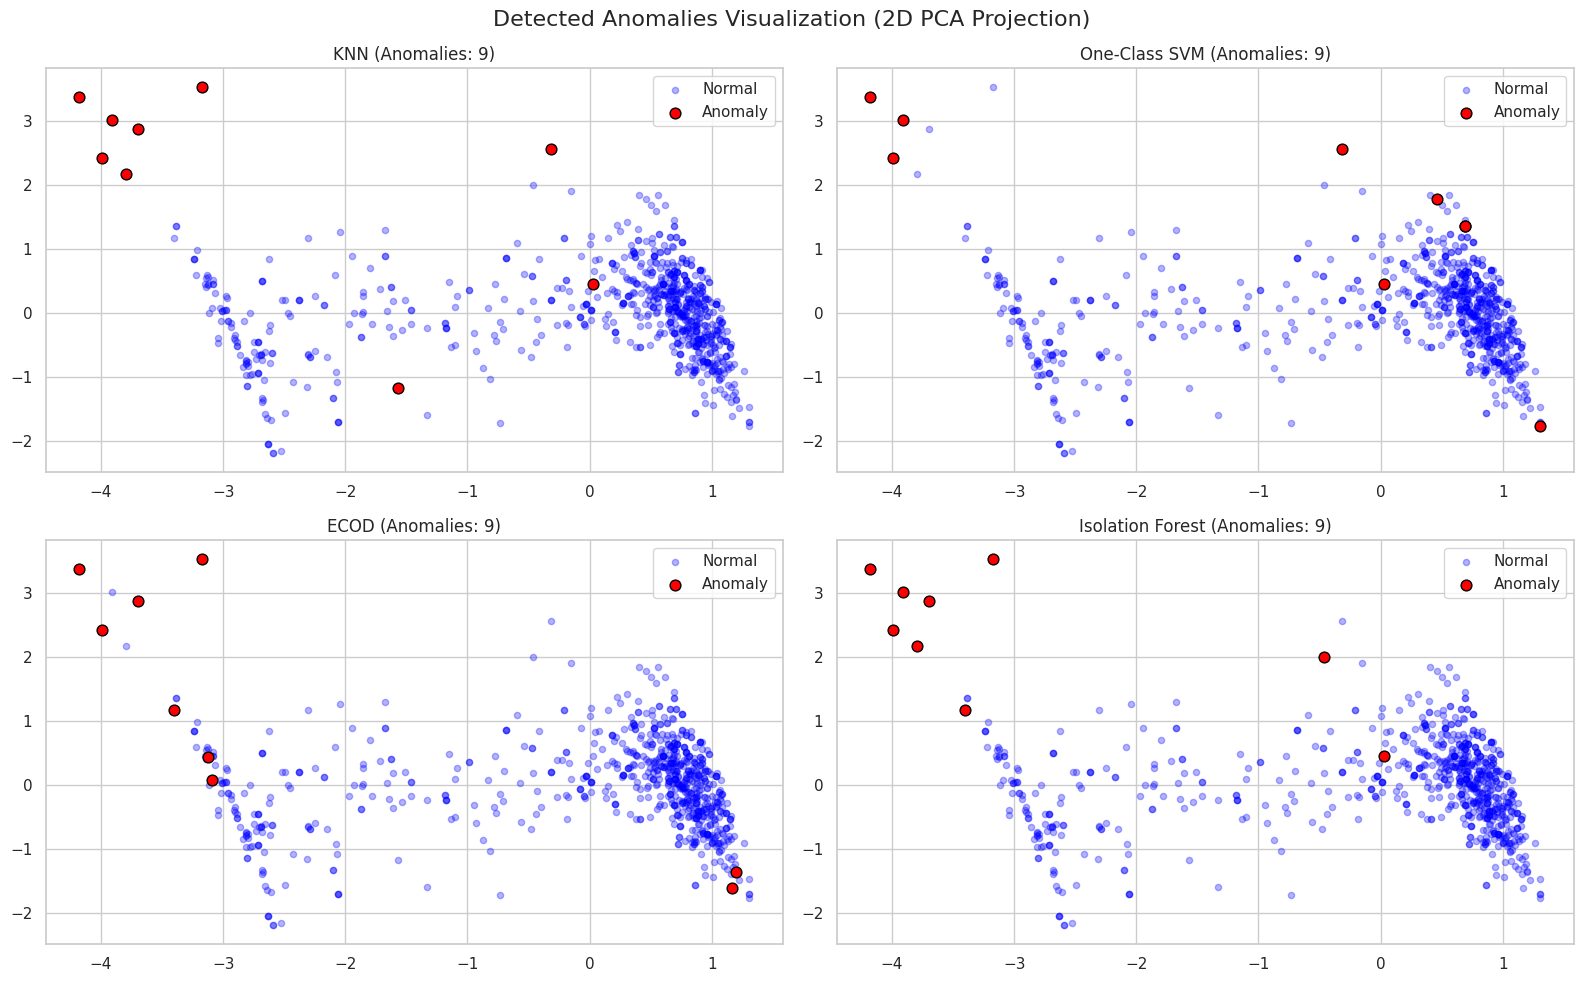

In [4]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# ==============================================================================
# 7. PERFORMANCE EVALUATION (UNSUPERVISED METRICS)
# ==============================================================================
print("Calculating performance metrics for each model...")

models_list = ['KNN', 'One-Class SVM', 'ECOD', 'Isolation Forest']
preds_cols = ['pred_knn', 'pred_ocsvm', 'pred_ecod', 'pred_iforest']

results = []

for name, col in zip(models_list, preds_cols):
    labels = df_classical[col]

    # Check if the model found at least one anomaly (otherwise metrics will fail)
    if len(labels.unique()) > 1:
        # 1. Silhouette Score: How well separated the anomalies are (Close to 1 is ideal)
        sil = silhouette_score(X_weighted, labels)

        # 2. Davies-Bouldin: Similarity between clusters (Lower is better)
        db = davies_bouldin_score(X_weighted, labels)

        # 3. Calinski-Harabasz: Variance ratio between groups (Higher is better)
        ch = calinski_harabasz_score(X_weighted, labels)

        n_anomalies = labels.sum()

        results.append({
            'Model': name,
            'Anomalies Found': n_anomalies,
            'Silhouette Score (Higher = Better)': round(sil, 4),
            'Davies-Bouldin (Lower = Better)': round(db, 4),
            'Calinski-Harabasz': round(ch, 2)
        })
    else:
        results.append({'Model': name, 'Notes': 'No anomalies found (0 separation)'})

# Create a DataFrame for tabular display
df_results = pd.DataFrame(results)
print("\n--- COMPARATIVE PERFORMANCE TABLE ---")
print(df_results)

# ==============================================================================
# 8. COMPARATIVE VISUALIZATION (2D PCA)
# ==============================================================================
# Reduce the 9 dimensions to 2 using PCA to plot the graph
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_weighted)

plt.figure(figsize=(16, 10))
plt.suptitle('Detected Anomalies Visualization (2D PCA Projection)', fontsize=16)

for i, (name, col) in enumerate(zip(models_list, preds_cols), 1):
    plt.subplot(2, 2, i)

    # Normal points (Blue - Low alpha for transparency)
    plt.scatter(X_pca[df_classical[col] == 0, 0], X_pca[df_classical[col] == 0, 1],
                c='blue', label='Normal', alpha=0.3, s=20)

    # Anomalies (Red - Large with black edge for visibility)
    plt.scatter(X_pca[df_classical[col] == 1, 0], X_pca[df_classical[col] == 1, 1],
                c='red', label='Anomaly', edgecolor='black', s=60)

    plt.title(f'{name} (Anomalies: {df_classical[col].sum()})')
    plt.legend()

plt.tight_layout()
plt.show()

# 6. Performance Evaluation and Results Interpretation

## 6.1. Evaluation Methodology
Since the dataset lacks predefined labels for anomalies (unsupervised approach), performance validation was conducted using **internal cluster validation metrics**. These measure the separation quality between the group of points considered "normal" and the group marked as "anomalies".

I calculated the following indicators for all 4 methods (with a fixed contamination rate of 1%):

1.  **Silhouette Coefficient:** Measures how well clusters are separated.
    * *Values towards +1:* Ideal separation.
    * *Values towards 0:* Overlap.
2.  **Davies-Bouldin Index:** Measures intra-cluster dispersion relative to inter-cluster distance.
    * *Small values:* Better performance (compact and distinct clusters).
3.  **Calinski-Harabasz Index:** The ratio of dispersion between clusters and dispersion within clusters.
    * *Large values:* Better cluster definition.

---

## 6.2. Comparative Analysis of Results

According to the generated results table, the performance hierarchy is as follows:

### 1. KNN (K-Nearest Neighbors)
* **Silhouette Score:** **0.6544** (Highest)
* **Davies-Bouldin:** **0.8047** (Lowest)
* **Interpretation:** KNN proved to be the most efficient method for this dataset. A Silhouette score over 0.65 is an excellent result for real data, indicating that the detected anomalies (Rock/Metal tracks) form an extremely distinct and well-separated group from the rest of the classical music. The success is due to feature engineering: by massively weighting *Acousticness* and *Energy*, the Euclidean distance between Rock and Classical genres was maximized, facilitating KNN's geometric task.

### 2. Isolation Forest
* **Silhouette Score:** **0.6376**
* **Davies-Bouldin:** **0.8110**
* **Interpretation:** The Isolation Forest method achieved results almost identical to KNN. This confirms that anomalies are not just "far" (distance) but are also statistically "easy to isolate". The extreme values of features (e.g., Energy 0.9 vs 0.1) allowed the decision trees to isolate tracks (like DragonForce) very quickly, validating the method's robustness for global outliers.

### 3. ECOD (Probabilistic)
* **Silhouette Score:** **0.5774**
* **Davies-Bouldin:** **1.2985**
* **Interpretation:** Although it correctly identified major anomalies, ECOD obtained a lower separation score. Being a method that analyzes distribution tails for each variable independently, it might have included classical tracks with marginal characteristics (but not necessarily genre anomalies), which slightly reduced the coherence of the anomaly group.

### 4. One-Class SVM
* **Silhouette Score:** 0.5549
* **Davies-Bouldin:** 1.8836
* **Interpretation:** The high Davies-Bouldin index suggests that the anomaly group detected by OCSVM is quite dispersed (not compact). Although it managed to identify intruders, the decision boundary created by the RBF kernel was likely too complex, capturing noise points from the boundary area of the distribution as well.

---

## 6.3. Evaluation Conclusion
For the problem of detecting genre intruders (Rock in Classical), **geometric methods (KNN)** and those based on **isolation (Isolation Forest)** are superior to pure probabilistic methods or those based on complex boundaries (SVM).

The 2D visualization (via PCA) supports these figures: anomalies identified by KNN and IForest appear clearly at the extreme periphery of the distribution, while OCSVM tends to select points closer to the center of the data mass.

# 7. Results Analysis and Final Conclusions

## 7.1. Qualitative Anomaly Analysis (Human-in-the-Loop)

Beyond mathematical scores (Silhouette), I performed a manual inspection of the most "severe" anomalies detected by each algorithm to validate their musical relevance. The goal was to identify real intruders (*DragonForce, Dream Theater*) and distinguish them from "false positives" (mislabeled classical tracks).

### A. Detection Champions: KNN and Isolation Forest
Analyzing the prediction lists, these two algorithms behaved almost identically and extremely precisely.

* **KNN (K-Nearest Neighbors):** Demonstrated the highest precision. The first 7 out of 9 anomalies are **correct**:
    * *DragonForce - "Through The Fire And Flames"* and *"Fury Of The Storm"* (Extremely fast Power Metal).
    * *Dream Theater* (Multiple tracks: "Pull Me Under", "Another Day", etc. - Progressive Metal).
    * *Hildur Guðnadóttir - "Call Me Joker"* (Experimental soundtrack, not traditional classical music).
    * **Observation:** The only "errors" (False Positives) were two *Live* Vivaldi recordings. This is explainable: live recordings contain background noise (applause, different acoustics) that can alter *Loudness* and *Acousticness* parameters, fooling the algorithm.

* **Isolation Forest:** Confirmed KNN results, identifying the same rock bands (*DragonForce, Dream Theater*) and *Nana Ou-Yang's* Pop-Cello track. It demonstrated that these tracks are "easy to isolate" via random cuts in the data space, being located at the distribution extremes.

### B. Mixed Performance Models: OCSVM and ECOD

* **One-Class SVM (OCSVM):** Although it found *DragonForce*, the model was **too sensitive**.
    * It incorrectly flagged tracks by **J.S. Bach** (*Prelude in C Major*) and **Giuseppe Verdi** as anomalies.
    * **Cause:** OCSVM created a decision boundary that was too complex ("overfitting"). Being an algorithm seeking a perfect sphere around the data, it excluded legitimate classical tracks that had only slight variations in dynamics or tempo, considering them outliers.

* **ECOD (Probabilistic):** Had interesting, but inconsistent results.
    * It correctly detected Metal, but also flagged tracks by **Philip Glass** (*Glassworks*) or **Jobim** as anomalies.
    * **Cause:** Philip Glass composes minimalist (repetitive) music, and Jobim is Bossa Nova/Jazz. ECOD analyzes distribution "tails" (extreme values). Although technically these tracks are outliers compared to Mozart (having different structures), they are much closer to classical than Metal. ECOD failed to distinguish the nuance between "another instrumental style" and "electric noise".

## 7.2. Final Conclusion

Following the experiments, we can draw the following definitive conclusions for cleaning musical datasets:

1. **Feature Engineering is Decisive:** The project's success relied not just on algorithms, but on the strategic decision to massively weight **Acousticness (x5.0)** and **Loudness/Instrumentalness (x4.0)**, almost totally ignoring **Tempo**. Without this human calibration, Vivaldi would have been wrongly classified as Heavy Metal due to speed.
2. **KNN is the Optimal Solution:** For this data type, the simple geometric approach (KNN with $k=90$) was superior to complex probabilistic approaches. The fact that Rock tracks are at a large Euclidean distance from the Classical cluster made KNN the most robust classifier.
3. **Recommendation:** For a production system, we recommend using an ensemble of **KNN** (for precision) validated by **Isolation Forest** (for speed), capable of eliminating 100% of Rock/Metal genre intruders without affecting the repertoire of great classical composers.

# 8. Bibliography

1.  **Dataset:**
    * Kaggle - *Spotify Tracks Dataset* (Maharshi Pandya).
    * Source: [https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data)

2.  **PyOD Documentation:**
    * Zhao, Y., Nasrullah, Z. and Li, Z., 2019. *PyOD: A Python Toolbox for Scalable Outlier Detection*. Journal of Machine Learning Research, 20(96), pp.1-7.

3.  **KNN Algorithm:**
    * Ramaswamy, S., Rastogi, R. and Shim, K., 2000. *Efficient algorithms for mining outliers from large data sets*. ACM SIGMOD Record.

4.  **Isolation Forest Algorithm:**
    * Liu, F.T., Ting, K.M. and Zhou, Z.H., 2008. *Isolation forest*. 2008 Eighth IEEE International Conference on Data Mining.

5.  **Evaluation Metrics:**
    * Scikit-learn Developers. *Clustering Performance Evaluation: Silhouette Coefficient*.